<a href="https://colab.research.google.com/github/zhakazx/data-mining-assignments/blob/main/data_preparation_data_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Data Mining: Klasifikasi SMS Spam Berbahasa Indonesia 🇮🇩
Kelas B <br>
**Anggota:**
1. Muh Mahir Imam B
2. Harahman Abd Arib
3. Zhaka Hidayat Yasir

### 1. Import Library Dasar
Pertama impor library yang diperlukan untuk manipulasi data, preprocessing teks,
dan pembagian dataset.

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 12.5 MB/s eta 0:00:00


In [ ]:
# Untuk stemming Bahasa Indonesia
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
# Stopwords Bahasa Indonesia
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_id = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 2. Load Dataset
Muat dataset dari file CSV, file yang sudah diunduh dari Kaggle.

In [ ]:
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sms_spam_indo.csv', encoding='latin-1')
except FileNotFoundError:
    print("File tidak ditemukan.")

df.head()

,Kategori,Pesan
0,spam,Plg Yth: Simcard anda mendptkan bonus poin plu...
1,ham,Iya ih ko sedih sih gtau kapan lg ke bandung :(
2,ham,Kalau mau bikin model/controller mending per a...
3,ham,Selamat nama1. Semoga selalu menempuh hidup ya...
4,spam,Tingkatkan nilai isi ulang Anda selanjutnya mi...


### 3. Cek Informasi Dataset
Melihat jumlah baris, kolom, tipe data, dan distribusi label (spam vs ham).

In [ ]:
print("Informasi Dataset:")
df.info()

# Melihat Distribusi Kelas
print("\nDistribusi Label Spam vs Ham:")
print(df['Kategori'].value_counts())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kategori  1143 non-null   object
 1   Pesan     1143 non-null   object
dtypes: object(2)
memory usage: 18.0+ KB

Distribusi Label Spam vs Ham:
Kategori
spam    574
ham     569
Name: count, dtype: int64


### 4. Visualisasi Distribusi Kelas

/tmp/ipython-input-3227955868.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Kategori', palette=['#3498db', '#e74c3c'])


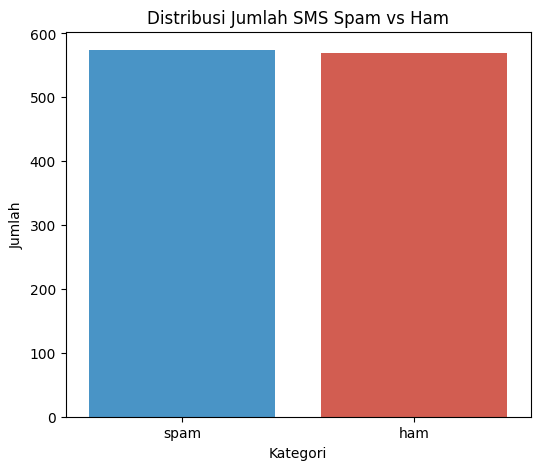

In [ ]:
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='Kategori', palette=['#3498db', '#e74c3c'])
plt.title('Distribusi Jumlah SMS Spam vs Ham')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.show()

Dari hasil eksplorasi awal, bisa dilihat bahwa dataset ini tidak seimbang (*imbalanced*), di mana jumlah SMS *spam* jauh lebih banyak daripada *ham*.

### 5. Visualisasi dengan Word Cloud

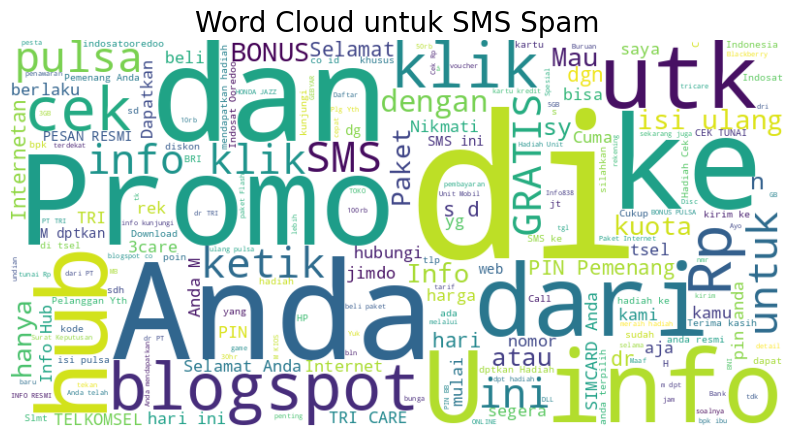

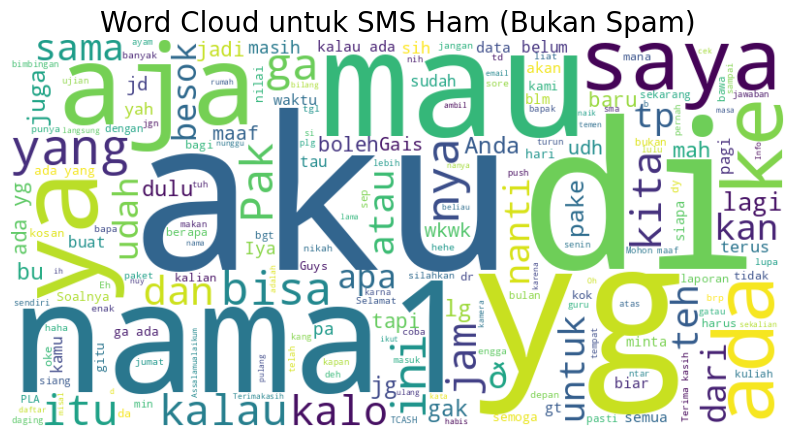

In [ ]:
# Visualisasi dengan Word Cloud

# Pisahkan teks untuk spam dan ham
spam_texts = " ".join(df[df['Kategori'] == 'spam']['Pesan'])
ham_texts = " ".join(df[df['Kategori'] == 'ham']['Pesan'])

# Word Cloud untuk SPAM
plt.figure(figsize=(10, 7))
wordcloud_spam = WordCloud(width=800, height=400, background_color='white').generate(spam_texts)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk SMS Spam', fontsize=20)
plt.show()

# Word Cloud untuk HAM
plt.figure(figsize=(10, 7))
wordcloud_ham = WordCloud(width=800, height=400, background_color='white').generate(ham_texts)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk SMS Ham (Bukan Spam)', fontsize=20)
plt.show()

### 7. Data Cleaning
- Mengubah semua teks ke huruf kecil (*case folding*).
- Menghapus URL, angka, tanda baca, dan karakter non-alfabet.

In [ ]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  return text

df['clean_text'] = df['Pesan'].astype(str).apply(clean_text)
df[['Pesan','clean_text']].head()

,Pesan,clean_text
0,Plg Yth: Simcard anda mendptkan bonus poin plu...,plg yth simcard anda mendptkan bonus poin plus...
1,Iya ih ko sedih sih gtau kapan lg ke bandung :(,iya ih ko sedih sih gtau kapan lg ke bandung
2,Kalau mau bikin model/controller mending per a...,kalau mau bikin modelcontroller mending per apa y
3,Selamat nama1. Semoga selalu menempuh hidup ya...,selamat nama semoga selalu menempuh hidup yang...
4,Tingkatkan nilai isi ulang Anda selanjutnya mi...,tingkatkan nilai isi ulang anda selanjutnya mi...


### 8. Tokenisasi, Stopword Removal, dan Stemming
- Tokenisasi: memecah teks jadi kata.
- Stopword removal: menghapus kata umum seperti "dan", "yang".
- Stemming: mengubah kata ke bentuk dasar dengan Sastrawi.

In [ ]:
def preprocess(text):
    # Tokenisasi
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_id]  # hapus stopword
    stems = [stemmer.stem(t) for t in tokens]         # stemming
    return " ".join(stems)

df['processed_text'] = df['clean_text'].apply(preprocess)
df[['clean_text','processed_text']].head()

,clean_text,processed_text
0,plg yth simcard anda mendptkan bonus poin plus...,plg yth simcard mendptkan bonus poin plusplus ...
1,iya ih ko sedih sih gtau kapan lg ke bandung,iya ih ko sedih sih gtau lg bandung
2,kalau mau bikin modelcontroller mending per apa y,bikin modelcontroller mending y
3,selamat nama semoga selalu menempuh hidup yang...,selamat nama moga tempuh hidup bahagia senang
4,tingkatkan nilai isi ulang anda selanjutnya mi...,tingkat nilai isi ulang minimal rpribu paket m...


# Menyimpan Dataset Hasil Preprocessing
Ditahap ini sudah memiliki kolom `processed_text`
yang berisi hasil preprocessing (cleaning, tokenisasi, stopword removal, dan stemming).
Sekarang simpan ke file CSV.

In [ ]:
# Simpan hanya kolom penting
df_preprocessed = df[['Kategori', 'processed_text']]

# Export ke CSV
df_preprocessed.to_csv("sms_spam_preprocessed.csv", index=False, encoding="utf-8")

print("File berhasil disimpan sebagai sms_spam_preprocessed.csv")

File berhasil disimpan sebagai sms_spam_preprocessed.csv
